# iQuHACK 2023

* Team name: HaQ

We chose to tackle the IonQ remote challenge.

This challenge had two major components: data encoding and decoding, and classification.

In [79]:
# Preamble: install everything we need
 #!pip install qiskit numpy matplotlib scipy qiskit_machine_learning sklearn

In [80]:
# Preamble: import everything we need
import numpy as np
import qiskit
import matplotlib.pyplot as plt
import scipy.fftpack
import qiskit_machine_learning.neural_networks
import qiskit_machine_learning.algorithms
import sklearn
import pickle

In [81]:
# Provided by IonQ
def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = qiskit.BasicAer.get_backend('statevector_simulator')
    job = qiskit.execute_function.execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram

In [82]:
# Helper functions
def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)


def shift_bit_length(x):
    return 1<<(x-1).bit_length()

## Encoding

Our input data are images of clothes, as part of the MNIST fashion dataset. So, for an image of $N \times N$ pixels, we consider some $N\times N$ matrix $D$, such that $D_{ij}$ is the brightness of the pixel in position $(i, j)$, normalized to be in the $[0,1]$ range.

It's easy to perform a straight-forward block-encoding of the matrix $D$, which
we started by doing: we note that we want a transformation that acts as

$$ \def\ket#1{\vert{#1}\rangle} \ket{i} \ket{j} \ket{0} \mapsto
      \ket{i} \ket{j} (\sqrt{D_{ij}} \ket{0} + \ldots \ket{1}) $$

which we can achieve with a controlled $R_y$ rotation on an auxilliary (the block-encoding) qubit, i.e.,

$$ D = \Pi_{i=1}^N \Pi_{j=1}^N \vert i \rangle\langle i \vert \otimes
  \vert j \rangle \langle j \vert \otimes R_y(2 \arccos \sqrt{D_{ij}})$$

Let this block-encoding of $D$ be $U_D$.

From this encoding, producing an FRQI encoding simply corresponds to applying
$U_D$ to a uniform superposition on the possible input indices.

$$ \vert \mbox{FRQI} \rangle = U_D (H^{\otimes n} \vert 0^n \rangle \otimes
  H^{\otimes n} \vert 0^n \rangle) $$

Then, decoding the image is just a matter of estimating the odds of measuring
$0$ in the last register, given that we measured a particular index position in
the first two registers:

$$ \tilde{D_{ij}} = \mbox{Prob}[i \oplus j \oplus 0 | i \oplus j] $$

Since we provided as input a uniform superposition of indices, we measure a given index with uniform probability.

We can see that this scheme works well:

In [83]:
def block_encoding(data):
    """Performs a block-encoding of the input data.
    
    Arguments:
        data      A numpy array that describes an NxN image in black & white,
                  with 0 corresponding to darkest, and 1 to brightest.
    
    Returns:
        A qiskit quantum circuit block-encoding the data in an auxiliary qubit.
    """
    # Check the dimensions of the input data
    r, c = np.shape(data)
    if r != c:
        raise ValueError("Error: Please provide a square image.")
    
    # Calculate how many qubits we'll need to represent indices into this data.
    n_qubits = int(np.ceil(np.log2(r)))
    print(f"Log: considering {n_qubits} qubits to index image side {r}")
    
    # Normalize the data to have infinity norm 1 (otherwise we can't BE it).
    # Also, just in case, to be positive semidefinite.
    data = (data + np.min(data)) / (np.max(data) - np.min(data))
    
    # What will hold our final BEing circuit.
    qubits = qiskit.QuantumRegister(2*n_qubits+1)
    circuit = qiskit.QuantumCircuit(qubits)

    for index_i in range(r):
        # Write i in binary.
        i_bin_str = '{ind:0{q}b}'.format(q=n_qubits, ind=index_i)
        i_binary = tuple(int(b) for b in i_bin_str)
        
        for index_j in range(c):
            # Write j in binary.
            j_bin_str = '{ind:0{q}b}'.format(q=n_qubits, ind=index_j)
            j_binary = tuple(int(b) for b in j_bin_str)
            
            # We are going to implement the action of D as a rotation, so we need
            # to know the ocrresponding angle.
            # Note that cirq's definition of rx considers the angle to be
            #  (arg)/2.
            angle = 2. * np.arccos(np.sqrt(data[index_i, index_j]))
            
            # The rotation is controlled by the relevant index register qubits.
            rotation = qiskit.circuit.library.RYGate(angle)
            rotation = rotation.control(num_ctrl_qubits=2*n_qubits,
                                        ctrl_state=(i_bin_str + j_bin_str)[::-1])
            circuit.append(rotation, qubits)
    
    return circuit

In [84]:
def frqi_encode(data):
    """Performs an FRQI encoding of the input data.
    
    Arguments:
        data      A numpy array that describes an NxN image in black & white,
                  with 0 corresponding to darkest, and 1 to brightest.
    
    Returns:
        A qiskit quantum circuit with an FRQI encoding of the data.
    """
    be_circuit = block_encoding(data)
    n_qubits = len(be_circuit.qubits)
    diffusion_circuit = qiskit.QuantumCircuit(n_qubits)
    for q_i in range(n_qubits-1):
        diffusion_circuit.h(q_i)
    diffusion_circuit.compose(be_circuit, inplace=True)
    return diffusion_circuit

Log: considering 2 qubits to index image side 4
     ┌───┐                                                                 »
q_0: ┤ H ├────o──────────o─────────────o─────────────o─────────────o───────»
     ├───┤    │          │             │             │             │       »
q_1: ┤ H ├────o──────────o─────────────o─────────────o─────────────■───────»
     ├───┤    │          │             │             │             │       »
q_2: ┤ H ├────o──────────o─────────────■─────────────■─────────────o───────»
     ├───┤    │          │             │             │             │       »
q_3: ┤ H ├────o──────────■─────────────o─────────────■─────────────o───────»
     └───┘┌───┴───┐┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐»
q_4: ─────┤ Ry(0) ├┤ Ry(0.6435) ├┤ Ry(1.3694) ├┤ Ry(2.2143) ├┤ Ry(0.9273) ├»
          └───────┘└────────────┘└────────────┘└────────────┘└────────────┘»
«                                                                        »
«q_0: ──────o─────────────o───

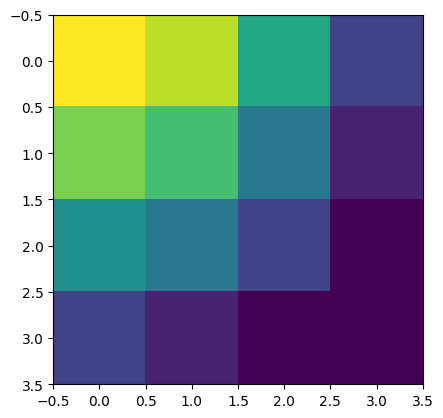

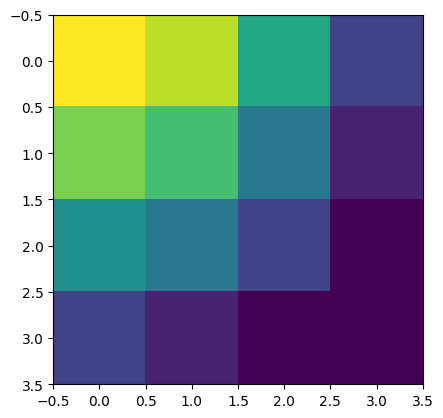

In [85]:
def test():
    data = np.array([[1.0, 0.9, 0.6, 0.2],
                     [0.8, 0.7, 0.4, 0.1],
                     [0.5, 0.4, 0.2, 0.0],
                     [0.2, 0.1, 0.0, 0.0]])
    circuit = frqi_encode(data)
    print(circuit)
    histogram = simulate(circuit)

    image_re = np.zeros(data.shape)
    for i in range(4):
        for j in range(4):
            key = (i << 2) + j
            key = '{:04b}'.format(key)
            key = int(key[::-1], 2)
            image_re[i, j] = histogram.get(key, 0.)

    plt.imshow(data)
    plt.show()
    plt.imshow(image_re)
    plt.show()

test()
del test

### Doing better

However, such a scheme requires one multi-controlled gate for each pixel of the 
image, i.e., if the image is $N \times N$, it requires $N^2$ multi-controlled gates. Furthermore, each of these multi-controlled gates is controlled by every
qubit in the indices register, meaning each gate has $2n$ controls. 

This was too demanding for our present case, so we took a different approach: instead of block-encoding (and the FRQI-encoding) the image itself, and inspired by, for example, the JPEG image format, we start by performing a Discrete Cosine Transformation on our input data.

This results in many zeroed entries, or very small entries, in the data, that we can consider in a single global phase shift. For the remaining non-small entries, which are, in principle, much fewer than $N^2$, we can have a controlled rotation as before for the necessary offset.

We further compress the input data by truncating high frequencies before we encode it into the quantum circuit.

In [86]:
def compress(image, size, eps=0):
    """Converts an image into its 2D-DCT, with some normalization."""
    a = scipy.fftpack.dctn(image)
    comp_freqs = a[:size,:size]
    max_freq = np.max(np.abs(comp_freqs))
    return comp_freqs/max_freq, max_freq

def decompress(freqs, scale, size):
    """Converts an image in 2D-DCT space back to real space."""
    new_freqs = np.zeros((size, size))
    s = freqs.shape[0]
    new_freqs[:s,:s] = freqs/scale
    reconstructed_image = scipy.fftpack.idctn(new_freqs)
    return reconstructed_image

In [87]:
def encode(image, eps=1e-6):
    if image.shape[0] != image.shape[1]:
        raise ValueError('Image must be square.')
    if np.min(image) < 0:
        raise ValueError('Image cannot have negative entries.')
    
    image_side = image.shape[0]
    n = image_side.bit_length() - 1
    
    q = qiskit.QuantumRegister(2*n+1)
    ct= qiskit.QuantumCircuit(q)
        
    # The DCT maps onto [-1, 1]; since we'll be estimating probabilities,
    # we need the domain to be [0, 1].
    image /= np.max(np.abs(image))
    image += 1
    image /= 2
    
    ct.h([qi for qi in q][:-1])
    
    for i in range(len(image)):
        for j in range(len(image[0])):
            
            aux_i = bin(i)[2:].zfill(n)
            aux_j = bin(j)[2:].zfill(n)
            
            theta = (image[i,j] - 0.5)*np.pi/2
            
            if abs(theta)>eps:
                rotation = qiskit.circuit.library.RYGate(2.*theta)
                rotation = rotation.control(num_ctrl_qubits=2*n,
                                            ctrl_state=(aux_i + aux_j))
                ct.append(rotation, q)
    ct.ry(2 * np.pi/4, q[-1])
            
    return ct

In [88]:
def decode(histogram, image_side):
    # This function considers that the histogram is actually the probabilities
    # computed via the wavefunction.
    index_reg_qubits = int(np.ceil(np.log2(image_side)))
    total_qubits = 2*index_reg_qubits + 1
    n_pixels = image_side**2

    # The matix to which we'll place our reconstructed image...
    data = np.zeros((image_side, image_side))
    
    for key in range(2**total_qubits):
        arr = bin_array(key, total_qubits)
        if arr[0]==0:
            arr_1, arr_2 = np.split(arr[1:], 2)
            c_1 = arr_1[::-1].dot(2**np.arange(arr_1.size)[::-1])
            c_2 = arr_2[::-1].dot(2**np.arange(arr_2.size)[::-1])
            data[c_2,c_1] = (4/np.pi) * np.arccos(np.sqrt(histogram.get(key,0.) * n_pixels)) - 1
            #print(key, arr_1, arr_2, c_1, c_2)

    return data

        ┌───┐                                                        »
q119_0: ┤ H ├─────o────────────■──────────────o──────────────■───────»
        ├───┤     │            │              │              │       »
q119_1: ┤ H ├─────o────────────o──────────────■──────────────■───────»
        └───┘┌────┴────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐»
q119_2: ─────┤ Ry(π/2) ├┤ Ry(0.61208) ├┤ Ry(0.65966) ├┤ Ry(0.17207) ├»
             └─────────┘└─────────────┘└─────────────┘└─────────────┘»
«                   
«q119_0: ───────────
«                   
«q119_1: ───────────
«        ┌─────────┐
«q119_2: ┤ Ry(π/2) ├
«        └─────────┘


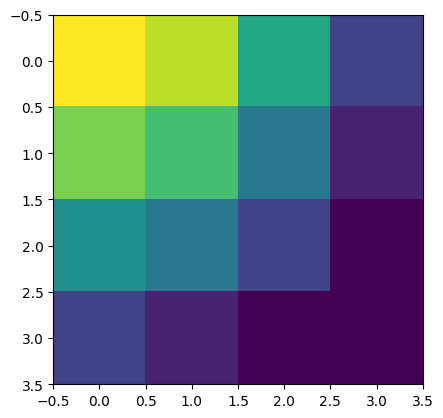

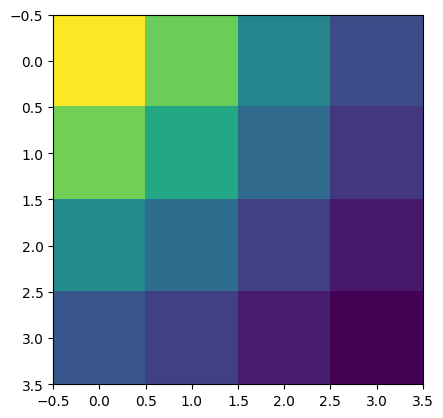

In [89]:
def test():
    data = np.array([[1.0, 0.9, 0.6, 0.2],
                        [0.8, 0.7, 0.4, 0.1],
                        [0.5, 0.4, 0.2, 0.0],
                        [0.2, 0.1, 0.0, 0.0]])

    freqs, scale = compress(data, 2)
    circuit=encode(freqs.copy(), eps=5e-2)
    print(circuit)
    histogram=simulate(circuit)
    freqs_re=decode(histogram, freqs.shape[0])
    image_re = decompress(freqs_re, scale, data.shape[0])

    plt.imshow(data)
    plt.show()
    plt.imshow(image_re)
    plt.show()

test()
del test

As shown above, this encoding scheme saves us gate depth and width, and works well.

We collected the relevant functions above into `submission_part1.py`.

## Classification

Now that we have an encoding and decoding scheme, we moved onto classification.

We chose to use a Quantum Convolutional Neural Network, for which Qiskit has already some facilities.

As described by the [Qiskit documentation][qcnn], the convolutional layers and the pooling layers are of the following stucture:

[qcnn]: https://qiskit.org/documentation/machine-learning/tutorials/11_quantum_convolutional_neural_networks.html

In [90]:
def conv_circuit(params):
    target = qiskit.circuit.QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

def conv_layer(num_qubits, param_prefix, do_barrier=False):
    qc = qiskit.circuit.QuantumCircuit(num_qubits,
                                       name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = qiskit.circuit.ParameterVector(param_prefix,
                                            length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(
            conv_circuit(params[param_index : (param_index + 3)]),
            [q1, q2])
        if do_barrier:
            qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(
            conv_circuit(params[param_index : (param_index + 3)]),
            [q1, q2])
        if do_barrier:
            qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = qiskit.circuit.QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

In [91]:
def show_conv():
    params = qiskit.circuit.ParameterVector("θ", length=3)
    circuit = conv_circuit(params)
    print("Convolution gadget:")
    print(circuit)
    print('')
    print("Convolution layer:")
    circuit = conv_layer(4, "θ", True)
    print(circuit.decompose())

show_conv()
del show_conv

Convolution gadget:
                 ┌───┐┌──────────┐                 ┌───┐┌─────────┐
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────┤ X ├┤ Rz(π/2) ├
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├──■─────────────
     └──────────┘     └──────────┘└───┘└──────────┘                

Convolution layer:
                 ┌───┐┌──────────┐                 ┌───┐┌─────────┐ ░ »
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────┤ X ├┤ Rz(π/2) ├─░─»
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘ ░ »
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├──■──────────────░─»
     └──────────┘     └──────────┘└───┘└──────────┘                 ░ »
q_2: ───────────────────────────────────────────────────────────────░─»
                                                                    ░ »
q_3: ───────────────────────────────────────────────────────────────░─»
                                            

In [92]:
def pool_circuit(params):
    target = qiskit.circuit.QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

def pool_layer(sources, sinks, param_prefix, do_barrier=False):
    num_qubits = len(sources) + len(sinks)
    qc = qiskit.circuit.QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = qiskit.circuit.ParameterVector(
        param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(
            pool_circuit(params[param_index : (param_index + 3)]),
            [source, sink])
        if do_barrier:
            qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = qiskit.circuit.QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


In [93]:
def show_pool():
    params = qiskit.circuit.ParameterVector("θ", length=3)
    circuit = pool_circuit(params)
    print('Pooling gadget:')
    print(circuit)
    print('')

    sources = [0, 1]
    sinks = [2, 3]
    circuit = pool_layer(sources, sinks, "θ", True)
    print('Pooling layer:')
    print(circuit.decompose())

show_pool()
del show_pool

Pooling gadget:
                 ┌───┐┌──────────┐                 
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├
     └──────────┘     └──────────┘└───┘└──────────┘

Pooling layer:
                 ┌───┐┌──────────┐                  ░                  »
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■───────────────░──────────────────»
                 └─┬─┘└──────────┘  │               ░             ┌───┐»
q_1: ──────────────┼────────────────┼───────────────░─────────────┤ X ├»
     ┌──────────┐  │  ┌──────────┐┌─┴─┐┌──────────┐ ░             └─┬─┘»
q_2: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├─░───────────────┼──»
     └──────────┘     └──────────┘└───┘└──────────┘ ░ ┌──────────┐  │  »
q_3: ───────────────────────────────────────────────░─┤ Rz(-π/2) ├──■──»
                                                    ░ └──────────┘     »
«                                   ░ 
«q_0: ──────

To train the circuit, we de-biased the training data, and used the encoder circuit defined before and a QCNN.

In [94]:
# Load the images
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')

# De-bias them by subtracting the average pixel-by-pixel, and convert to
# frequency space with the previously described compressions.
ind = 500
n = 100
s = 4
main_images = images[ind-n//2:ind+n//2]
mean_image = np.mean(images, axis=0)
main_images -= mean_image
train_images = np.zeros((main_images.shape[0],s,s))
scales = np.zeros(main_images.shape[0])
for i, image in enumerate(main_images):
    train_images[i], scales[i] = compress(image, s)
mean_image = np.mean(train_images, axis=0)
train_images -= mean_image
train_images = train_images.reshape(n, -1)
train_labels = labels[ind-n//2:ind+n//2].astype(int)*2-1

# A circuit that's like our encoder, but with parameters
def encode_par(parV, eps=1e-6):
    image_side = int(np.sqrt(len(parV)))
    n = int(np.log2(np.sqrt(len(parV))))#image_side.bit_length() - 1
    q = qiskit.QuantumRegister(shift_bit_length(2*n+1))
    ct= qiskit.QuantumCircuit(q)
    ct.h([qi for qi in q][:2*n])
    for i in range(image_side):
        for j in range(image_side):
            
            aux_i = bin(i)[2:].zfill(n)
            aux_j = bin(j)[2:].zfill(n)
            
            theta = (parV[i*image_side+j]-0.5)*np.pi/2
            
            rotation = qiskit.circuit.library.RYGate(2.*theta)
            rotation = rotation.control(num_ctrl_qubits=2*n,
                                        ctrl_state=(aux_i + aux_j)[::-1])
            ct.append(rotation, q[:2*n+1])
                        
    ct.ry(2 * np.pi/4, q[2*n])
    return ct


# Classifier circuit

ip = qiskit.circuit.ParameterVector('ip',s*s)
my_feature = encode_par(ip)

ns = 8
ansatz = qiskit.QuantumCircuit(ns, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(ns)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(ns)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(ns-4,ns)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(ns-4,ns)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(ns-2,ns)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(ns-2, ns)), inplace=True)

# Combining the feature map and ansatz
circuit = qiskit.circuit.QuantumCircuit(ns)
circuit.compose(my_feature, range(ns), inplace=True)
circuit.compose(ansatz, range(ns), inplace=True)

observable = qiskit.quantum_info.SparsePauliOp.from_list([("Z" + "I" * (ns-1), 1)])

qnn = qiskit_machine_learning.neural_networks.EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=ip,
    weight_params=ansatz.parameters,
)

In [95]:
# Some training code happened here...

In [96]:
# As a result of the training, we got the following parameters:
z  = np.array([6.09293191, 4.61274128, 1.86474247, 2.17477085, 5.64851591,
               1.18473261, 7.25350397, 3.23874789, 5.33300462, 5.71626242,
               1.26991389, 7.06105309, 4.90201957, 2.50547602, 0.62319825,
               5.74657538, 2.76919504, 1.52856003, 1.86586136, 5.28731049,
               4.31314045, 6.27829045, 6.16826691, 4.97197601, 3.31255369,
               0.26758544, 4.65917013, 1.72973807, 0.57235066, 2.64881671,
               3.017045  , 1.89665937, 5.11352272, 3.31972731, 4.51316688,
               6.06122793, 1.84412712, 1.49538476, 0.89315718, 2.20726404,
               5.11189485, 5.255032  , 4.60454055, 1.93476487, 4.88235973,
               1.91190421, 3.99671993, 3.81718927, 5.50201263, 4.19659843,
               4.87344166, 5.30039778, 0.37703921, 0.73940664, 4.53613702,
               4.76094938, 3.61371364, 1.16640741, 5.70574491, 5.05496212,
               2.13525846, 2.66798457, 4.34976548])

In [97]:
# Assign those parameters to our QNN
filled_ansatz = ansatz.assign_parameters(z).decompose()
print(filled_ansatz)

                 ┌───┐┌────────────────┐                       ┌───┐┌─────────┐»
q_0: ────────────┤ X ├┤ Rz(2.20726404) ├──■────────────────────┤ X ├┤ Rz(π/2) ├»
     ┌──────────┐└─┬─┘├────────────────┤┌─┴─┐ ┌──────────────┐ └─┬─┘└─────────┘»
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(5.11189485) ├┤ X ├─┤ Ry(5.255032) ├───■─────────────»
     └──────────┘┌───┐├────────────────┤└───┘ └──────────────┘ ┌───┐┌─────────┐»
q_2: ────────────┤ X ├┤ Rz(4.60454055) ├──■────────────────────┤ X ├┤ Rz(π/2) ├»
     ┌──────────┐└─┬─┘├────────────────┤┌─┴─┐┌────────────────┐└─┬─┘└─────────┘»
q_3: ┤ Rz(-π/2) ├──■──┤ Ry(1.93476487) ├┤ X ├┤ Ry(4.88235973) ├──■─────────────»
     └──────────┘┌───┐├────────────────┤└───┘└────────────────┘┌───┐┌─────────┐»
q_4: ────────────┤ X ├┤ Rz(1.91190421) ├──■────────────────────┤ X ├┤ Rz(π/2) ├»
     ┌──────────┐└─┬─┘├────────────────┤┌─┴─┐┌────────────────┐└─┬─┘└─────────┘»
q_5: ┤ Rz(-π/2) ├──■──┤ Ry(3.99671993) ├┤ X ├┤ Ry(3.81718927) ├──■─────────────»
     └──────────┘┌───┐├─────

In [98]:
output_optimized = qiskit.transpile(filled_ansatz,
                                    basis_gates=['u','cx'],
                                    optimization_level=3)

In [99]:
print('Operation count before transpilation:')
print(filled_ansatz.count_ops())

print('Operation count after transpilation:')
print(output_optimized.count_ops())

Operation count before transpilation:
OrderedDict([('rz', 56), ('cx', 56), ('ry', 42)])
Operation count after transpilation:
OrderedDict([('u', 68), ('cx', 50)])


In [100]:
# Save it to a .pickle file, to load it in submission_part2.
with open('submission_classifier.pickle', 'wb') as outfile:
    pickle.dump(filled_ansatz, outfile)

filled_ansatz.qasm(filename='submission_classifier.qasm')

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[8];\nrz(-pi/2) q[1];\ncx q[1],q[0];\nrz(2.20726404) q[0];\nry(5.11189485) q[1];\ncx q[0],q[1];\nry(5.255032) q[1];\ncx q[1],q[0];\nrz(pi/2) q[0];\nrz(-pi/2) q[0];\nrz(-pi/2) q[3];\ncx q[3],q[2];\nrz(4.60454055) q[2];\nry(1.93476487) q[3];\ncx q[2],q[3];\nry(4.88235973) q[3];\ncx q[3],q[2];\nrz(pi/2) q[2];\nrz(-pi/2) q[2];\ncx q[2],q[1];\nrz(5.30039778) q[1];\nry(0.37703921) q[2];\ncx q[1],q[2];\nry(0.73940664) q[2];\ncx q[2],q[1];\nrz(pi/2) q[1];\nrz(-pi/2) q[5];\ncx q[5],q[4];\nrz(1.91190421) q[4];\nry(3.99671993) q[5];\ncx q[4],q[5];\nry(3.81718927) q[5];\ncx q[5],q[4];\nrz(pi/2) q[4];\nrz(-pi/2) q[4];\ncx q[4],q[3];\nrz(4.53613702) q[3];\nry(4.76094938) q[4];\ncx q[3],q[4];\nry(3.61371364) q[4];\ncx q[4],q[3];\nrz(pi/2) q[3];\nrz(-pi/2) q[4];\nrz(-pi/2) q[7];\ncx q[7],q[6];\nrz(5.50201263) q[6];\nry(4.19659843) q[7];\ncx q[6],q[7];\nry(4.87344166) q[7];\ncx q[7],q[6];\ncx q[0],q[7];\nry(2.66798457) q[0];\nrz(pi/2) q[6];\nrz(-pi/2) q[6];\